In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '4'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_ch_32_DO(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=5, filters=32, strides=1, 
                      padding='same', input_shape=input_shape)) 
    model.add(Activation('relu'))
#     model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=5, filters=32*(2**int((i+1)/4)), 
                          strides=1, padding='same'))
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    model.add(Dropout(0.75))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(3, 10):
    model = build_1d_cnn_custom_ch_32_DO(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 32)         192       
_________________________________________________________________
activation (Activation)      (None, 16000, 32)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16000, 32)         5152      
_________________________________________________________________
activation_1 (Activation)    (None, 16000, 32)         0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 5333, 32)          0         
_________________________________________________________________
conv1d_2 (Conv1D)    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_18 (Conv1D)           (None, 16000, 32)         192       
_________________________________________________________________
activation_18 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 16000, 32)         5152      
_________________________________________________________________
activation_19 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 5333, 32)          0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 5333, 32)          5152      
_________________________________________________________________
activation_20 (Activation)   (None, 5333, 32)          0         
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3532 - acc: 0.2358
Epoch 00001: val_loss improved from inf to 2.32846, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_075_DO_SGD_3_conv_checkpoint/001-2.3285.hdf5
36805/36805 [==============================] - 24s 662us/sample - loss: 2.3532 - acc: 0.2358 - val_loss: 2.3285 - val_acc: 0.2269
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7470 - acc: 0.4318
Epoch 00002: val_loss improved from 2.32846 to 1.63503, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_075_DO_SGD_3_conv_checkpoint/002-1.6350.hdf5
36805/36805 [==============================] - 23s 628us/sample - loss: 1.7471 - acc: 0.4318 - val_loss: 1.6350 - val_acc: 0.4715
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4462 - acc: 0.5325
Epoch 00003: val_loss improved from 1.63503 t

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4398 - acc: 0.8537
Epoch 00027: val_loss did not improve from 1.08949
36805/36805 [==============================] - 22s 599us/sample - loss: 0.4398 - acc: 0.8537 - val_loss: 1.2047 - val_acc: 0.7016
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4418 - acc: 0.8544
Epoch 00028: val_loss did not improve from 1.08949
36805/36805 [==============================] - 22s 597us/sample - loss: 0.4417 - acc: 0.8544 - val_loss: 1.2149 - val_acc: 0.6890
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4181 - acc: 0.8629
Epoch 00029: val_loss did not improve from 1.08949
36805/36805 [==============================] - 22s 597us/sample - loss: 0.4182 - acc: 0.8628 - val_loss: 1.3526 - val_acc: 0.6583
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4220 - acc: 0.8621
Epoch 00030: val_loss improved from 1.08949 to 1.08253, saving model 

36800/36805 [============================>.] - ETA: 0s - loss: 0.3353 - acc: 0.8906
Epoch 00056: val_loss did not improve from 1.08253
36805/36805 [==============================] - 22s 596us/sample - loss: 0.3357 - acc: 0.8906 - val_loss: 1.3299 - val_acc: 0.6606
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3655 - acc: 0.8804
Epoch 00057: val_loss did not improve from 1.08253
36805/36805 [==============================] - 22s 597us/sample - loss: 0.3656 - acc: 0.8804 - val_loss: 1.1738 - val_acc: 0.7091
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3332 - acc: 0.8923
Epoch 00058: val_loss did not improve from 1.08253
36805/36805 [==============================] - 22s 601us/sample - loss: 0.3332 - acc: 0.8922 - val_loss: 1.2036 - val_acc: 0.7077
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3288 - acc: 0.8919
Epoch 00059: val_loss did not improve from 1.08253
36805/36805 [==================

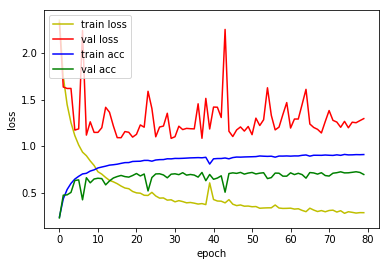

4815/4815 [==============================] - 2s 318us/sample - loss: 1.1766 - acc: 0.6762
Loss: 1.1766346916355201 Accuracy: 0.6762201

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2654 - acc: 0.2511
Epoch 00001: val_loss improved from inf to 1.71526, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_075_DO_SGD_4_conv_checkpoint/001-1.7153.hdf5
36805/36805 [==============================] - 24s 661us/sample - loss: 2.2653 - acc: 0.2511 - val_loss: 1.7153 - val_acc: 0.4372
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6855 - acc: 0.4487
Epoch 00002: val_loss did not improve from 1.71526
36805/36805 [==============================] - 23s 628us/sample - loss: 1.6855 - acc: 0.4487 - val_loss: 1.9489 - val_acc: 0.4018
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3383 - acc: 0.5700
Epoch 00003: val_loss improved from 1.71526 to 1.20569, saving 

36800/36805 [============================>.] - ETA: 0s - loss: 2.7205 - acc: 0.0808
Epoch 00028: val_loss did not improve from 0.78380
36805/36805 [==============================] - 23s 622us/sample - loss: 2.7205 - acc: 0.0807 - val_loss: 2.7185 - val_acc: 0.0776
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.7205 - acc: 0.0811
Epoch 00029: val_loss did not improve from 0.78380
36805/36805 [==============================] - 23s 621us/sample - loss: 2.7205 - acc: 0.0811 - val_loss: 2.7189 - val_acc: 0.0818
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.7206 - acc: 0.0804
Epoch 00030: val_loss did not improve from 0.78380
36805/36805 [==============================] - 23s 622us/sample - loss: 2.7206 - acc: 0.0803 - val_loss: 2.7182 - val_acc: 0.0820
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.7205 - acc: 0.0792
Epoch 00031: val_loss did not improve from 0.78380
36805/36805 [==================


1D_CNN_custom_ch_32_DO_075_DO_SGD_4_conv Model


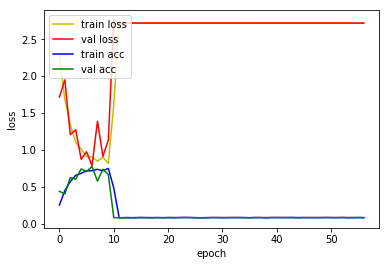

4815/4815 [==============================] - 2s 387us/sample - loss: 0.8981 - acc: 0.7304
Loss: 0.8980849098193683 Accuracy: 0.7304258

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3061 - acc: 0.2391
Epoch 00001: val_loss improved from inf to 1.73793, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_075_DO_SGD_5_conv_checkpoint/001-1.7379.hdf5
36805/36805 [==============================] - 26s 696us/sample - loss: 2.3061 - acc: 0.2391 - val_loss: 1.7379 - val_acc: 0.4482
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6669 - acc: 0.4488
Epoch 00002: val_loss did not improve from 1.73793
36805/36805 [==============================] - 24s 652us/sample - loss: 1.6672 - acc: 0.4488 - val_loss: 2.1400 - val_acc: 0.2483
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3728 - acc: 0.5587
Epoch 00003: val_loss did not improve from 1.73793
36805/36805 

36800/36805 [============================>.] - ETA: 0s - loss: 0.4882 - acc: 0.8452
Epoch 00027: val_loss did not improve from 0.52188
36805/36805 [==============================] - 24s 647us/sample - loss: 0.4882 - acc: 0.8452 - val_loss: 0.6605 - val_acc: 0.8358
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4794 - acc: 0.8482
Epoch 00028: val_loss improved from 0.52188 to 0.51137, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_075_DO_SGD_5_conv_checkpoint/028-0.5114.hdf5
36805/36805 [==============================] - 24s 644us/sample - loss: 0.4794 - acc: 0.8482 - val_loss: 0.5114 - val_acc: 0.8626
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4828 - acc: 0.8476
Epoch 00029: val_loss did not improve from 0.51137
36805/36805 [==============================] - 24s 645us/sample - loss: 0.4829 - acc: 0.8475 - val_loss: 0.5644 - val_acc: 0.8418
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - los

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3981 - acc: 0.8722
Epoch 00056: val_loss did not improve from 0.47403
36805/36805 [==============================] - 24s 645us/sample - loss: 0.3982 - acc: 0.8722 - val_loss: 0.5947 - val_acc: 0.8404
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4046 - acc: 0.8715
Epoch 00057: val_loss did not improve from 0.47403
36805/36805 [==============================] - 24s 647us/sample - loss: 0.4046 - acc: 0.8715 - val_loss: 0.5293 - val_acc: 0.8551
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3930 - acc: 0.8723
Epoch 00058: val_loss did not improve from 0.47403
36805/36805 [==============================] - 24s 643us/sample - loss: 0.3931 - acc: 0.8722 - val_loss: 0.5263 - val_acc: 0.8532
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4019 - acc: 0.8726
Epoch 00059: val_loss did not improve from 0.47403
36805/36805 [=====

Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3516 - acc: 0.8877
Epoch 00086: val_loss did not improve from 0.47403
36805/36805 [==============================] - 24s 646us/sample - loss: 0.3517 - acc: 0.8877 - val_loss: 0.5060 - val_acc: 0.8691
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3524 - acc: 0.8852
Epoch 00087: val_loss did not improve from 0.47403
36805/36805 [==============================] - 24s 647us/sample - loss: 0.3525 - acc: 0.8852 - val_loss: 0.5559 - val_acc: 0.8721
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3476 - acc: 0.8871
Epoch 00088: val_loss did not improve from 0.47403
36805/36805 [==============================] - 24s 642us/sample - loss: 0.3476 - acc: 0.8871 - val_loss: 0.7151 - val_acc: 0.8132
Epoch 89/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3442 - acc: 0.8879
Epoch 00089: val_loss did not improve from 0.47403
36805/36805 [=====

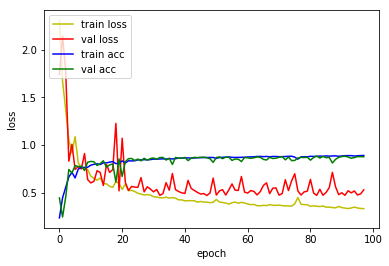

4815/4815 [==============================] - 2s 357us/sample - loss: 0.5932 - acc: 0.8395
Loss: 0.5932148873125157 Accuracy: 0.83946

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.5915 - acc: 0.1421
Epoch 00001: val_loss improved from inf to 1.88919, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_075_DO_SGD_6_conv_checkpoint/001-1.8892.hdf5
36805/36805 [==============================] - 27s 725us/sample - loss: 2.5914 - acc: 0.1422 - val_loss: 1.8892 - val_acc: 0.3986
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8192 - acc: 0.3962
Epoch 00002: val_loss improved from 1.88919 to 1.84569, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_075_DO_SGD_6_conv_checkpoint/002-1.8457.hdf5
36805/36805 [==============================] - 24s 660us/sample - loss: 1.8191 - acc: 0.3962 - val_loss: 1.8457 - val_acc: 0.4167
Epoch 3/500
36800/36805 [============================>.

36800/36805 [============================>.] - ETA: 0s - loss: 0.4182 - acc: 0.8711
Epoch 00025: val_loss improved from 0.32155 to 0.31315, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_075_DO_SGD_6_conv_checkpoint/025-0.3132.hdf5
36805/36805 [==============================] - 24s 661us/sample - loss: 0.4181 - acc: 0.8711 - val_loss: 0.3132 - val_acc: 0.9143
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4169 - acc: 0.8715
Epoch 00026: val_loss did not improve from 0.31315
36805/36805 [==============================] - 24s 656us/sample - loss: 0.4171 - acc: 0.8715 - val_loss: 0.3986 - val_acc: 0.8938
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4116 - acc: 0.8734
Epoch 00027: val_loss did not improve from 0.31315
36805/36805 [==============================] - 24s 655us/sample - loss: 0.4116 - acc: 0.8734 - val_loss: 0.4206 - val_acc: 0.8852
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - los

Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3256 - acc: 0.8967
Epoch 00053: val_loss improved from 0.28671 to 0.28265, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_075_DO_SGD_6_conv_checkpoint/053-0.2827.hdf5
36805/36805 [==============================] - 24s 657us/sample - loss: 0.3256 - acc: 0.8966 - val_loss: 0.2827 - val_acc: 0.9227
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3312 - acc: 0.8975
Epoch 00054: val_loss did not improve from 0.28265
36805/36805 [==============================] - 24s 655us/sample - loss: 0.3312 - acc: 0.8975 - val_loss: 0.3135 - val_acc: 0.9103
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3289 - acc: 0.8963
Epoch 00055: val_loss did not improve from 0.28265
36805/36805 [==============================] - 24s 653us/sample - loss: 0.3288 - acc: 0.8963 - val_loss: 0.2975 - val_acc: 0.9217
Epoch 56/500
36800/36805 [============================>.] - 

36800/36805 [============================>.] - ETA: 0s - loss: 0.2916 - acc: 0.9074
Epoch 00081: val_loss did not improve from 0.27018
36805/36805 [==============================] - 24s 656us/sample - loss: 0.2915 - acc: 0.9074 - val_loss: 0.3164 - val_acc: 0.9213
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2926 - acc: 0.9071
Epoch 00082: val_loss did not improve from 0.27018
36805/36805 [==============================] - 24s 651us/sample - loss: 0.2925 - acc: 0.9071 - val_loss: 0.2912 - val_acc: 0.9220
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2936 - acc: 0.9061
Epoch 00083: val_loss did not improve from 0.27018
36805/36805 [==============================] - 24s 653us/sample - loss: 0.2935 - acc: 0.9061 - val_loss: 0.2956 - val_acc: 0.9266
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2936 - acc: 0.9052
Epoch 00084: val_loss did not improve from 0.27018
36805/36805 [==================

36800/36805 [============================>.] - ETA: 0s - loss: 0.2898 - acc: 0.9066
Epoch 00110: val_loss did not improve from 0.25900
36805/36805 [==============================] - 24s 652us/sample - loss: 0.2898 - acc: 0.9065 - val_loss: 0.2948 - val_acc: 0.9245
Epoch 111/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2874 - acc: 0.9093
Epoch 00111: val_loss did not improve from 0.25900
36805/36805 [==============================] - 24s 651us/sample - loss: 0.2873 - acc: 0.9093 - val_loss: 0.3137 - val_acc: 0.9201
Epoch 112/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2799 - acc: 0.9109
Epoch 00112: val_loss did not improve from 0.25900
36805/36805 [==============================] - 24s 650us/sample - loss: 0.2801 - acc: 0.9109 - val_loss: 0.2921 - val_acc: 0.9229
Epoch 113/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2950 - acc: 0.9059
Epoch 00113: val_loss did not improve from 0.25900
36805/36805 [===============

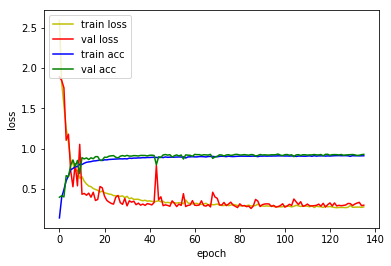

4815/4815 [==============================] - 2s 351us/sample - loss: 0.3395 - acc: 0.9063
Loss: 0.33951914914548087 Accuracy: 0.9063344

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.6926 - acc: 0.0986
Epoch 00001: val_loss improved from inf to 2.49706, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_075_DO_SGD_7_conv_checkpoint/001-2.4971.hdf5
36805/36805 [==============================] - 27s 733us/sample - loss: 2.6925 - acc: 0.0987 - val_loss: 2.4971 - val_acc: 0.1915
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1334 - acc: 0.2959
Epoch 00002: val_loss improved from 2.49706 to 2.43781, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_075_DO_SGD_7_conv_checkpoint/002-2.4378.hdf5
36805/36805 [==============================] - 24s 663us/sample - loss: 2.1334 - acc: 0.2959 - val_loss: 2.4378 - val_acc: 0.2113
Epoch 3/500
36800/36805 [===========================

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3564 - acc: 0.8910
Epoch 00024: val_loss did not improve from 0.21945
36805/36805 [==============================] - 24s 663us/sample - loss: 0.3564 - acc: 0.8910 - val_loss: 0.2207 - val_acc: 0.9380
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3420 - acc: 0.8929
Epoch 00025: val_loss did not improve from 0.21945
36805/36805 [==============================] - 24s 662us/sample - loss: 0.3420 - acc: 0.8929 - val_loss: 0.2239 - val_acc: 0.9378
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3351 - acc: 0.8954
Epoch 00026: val_loss did not improve from 0.21945
36805/36805 [==============================] - 24s 662us/sample - loss: 0.3351 - acc: 0.8954 - val_loss: 0.2889 - val_acc: 0.9248
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3256 - acc: 0.8994
Epoch 00027: val_loss did not improve from 0.21945
36805/36805 [=====

36800/36805 [============================>.] - ETA: 0s - loss: 0.2700 - acc: 0.9153
Epoch 00052: val_loss did not improve from 0.19373
36805/36805 [==============================] - 24s 660us/sample - loss: 0.2700 - acc: 0.9153 - val_loss: 0.2238 - val_acc: 0.9453
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2541 - acc: 0.9208
Epoch 00053: val_loss did not improve from 0.19373
36805/36805 [==============================] - 24s 662us/sample - loss: 0.2542 - acc: 0.9208 - val_loss: 0.2772 - val_acc: 0.9301
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2718 - acc: 0.9152
Epoch 00054: val_loss did not improve from 0.19373
36805/36805 [==============================] - 24s 659us/sample - loss: 0.2718 - acc: 0.9152 - val_loss: 0.2253 - val_acc: 0.9432
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2644 - acc: 0.9177
Epoch 00055: val_loss improved from 0.19373 to 0.18857, saving model to model/chec

36800/36805 [============================>.] - ETA: 0s - loss: 0.2636 - acc: 0.9178
Epoch 00081: val_loss did not improve from 0.18857
36805/36805 [==============================] - 24s 660us/sample - loss: 0.2635 - acc: 0.9178 - val_loss: 0.2230 - val_acc: 0.9411
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2422 - acc: 0.9236
Epoch 00082: val_loss did not improve from 0.18857
36805/36805 [==============================] - 24s 662us/sample - loss: 0.2422 - acc: 0.9236 - val_loss: 0.2437 - val_acc: 0.9439
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2448 - acc: 0.9232
Epoch 00083: val_loss did not improve from 0.18857
36805/36805 [==============================] - 24s 660us/sample - loss: 0.2448 - acc: 0.9232 - val_loss: 0.2088 - val_acc: 0.9485
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2302 - acc: 0.9258
Epoch 00084: val_loss did not improve from 0.18857
36805/36805 [==================

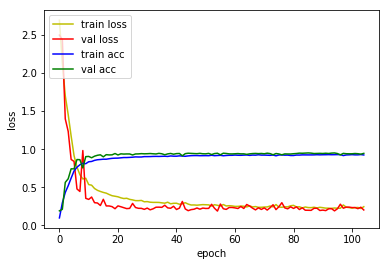

4815/4815 [==============================] - 2s 350us/sample - loss: 0.2312 - acc: 0.9352
Loss: 0.23115783570835277 Accuracy: 0.9352025

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.7053 - acc: 0.0954
Epoch 00001: val_loss improved from inf to 2.47142, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_075_DO_SGD_8_conv_checkpoint/001-2.4714.hdf5
36805/36805 [==============================] - 28s 755us/sample - loss: 2.7052 - acc: 0.0954 - val_loss: 2.4714 - val_acc: 0.1824
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2151 - acc: 0.2448
Epoch 00002: val_loss improved from 2.47142 to 2.02286, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_075_DO_SGD_8_conv_checkpoint/002-2.0229.hdf5
36805/36805 [==============================] - 25s 677us/sample - loss: 2.2152 - acc: 0.2448 - val_loss: 2.0229 - val_acc: 0.3312
Epoch 3/500
36800/36805 [===========================

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2569 - acc: 0.9209
Epoch 00026: val_loss improved from 0.16788 to 0.16628, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_075_DO_SGD_8_conv_checkpoint/026-0.1663.hdf5
36805/36805 [==============================] - 25s 681us/sample - loss: 0.2569 - acc: 0.9209 - val_loss: 0.1663 - val_acc: 0.9511
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2316 - acc: 0.9287
Epoch 00027: val_loss did not improve from 0.16628
36805/36805 [==============================] - 25s 678us/sample - loss: 0.2316 - acc: 0.9287 - val_loss: 0.1714 - val_acc: 0.9529
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2323 - acc: 0.9276
Epoch 00028: val_loss did not improve from 0.16628
36805/36805 [==============================] - 25s 680us/sample - loss: 0.2323 - acc: 0.9276 - val_loss: 0.1681 - val_acc: 0.9483
Epoch 29/500
36800/36805 [============================>.] - 

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2089 - acc: 0.9359
Epoch 00055: val_loss did not improve from 0.14794
36805/36805 [==============================] - 25s 679us/sample - loss: 0.2088 - acc: 0.9359 - val_loss: 0.1821 - val_acc: 0.9532
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1842 - acc: 0.9442
Epoch 00056: val_loss did not improve from 0.14794
36805/36805 [==============================] - 25s 678us/sample - loss: 0.1841 - acc: 0.9442 - val_loss: 0.2040 - val_acc: 0.9522
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1852 - acc: 0.9427
Epoch 00057: val_loss did not improve from 0.14794
36805/36805 [==============================] - 25s 678us/sample - loss: 0.1852 - acc: 0.9427 - val_loss: 0.1862 - val_acc: 0.9522
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1848 - acc: 0.9435
Epoch 00058: val_loss did not improve from 0.14794
36805/36805 [=====

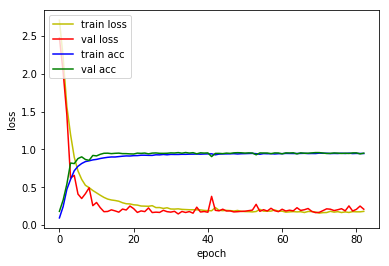

4815/4815 [==============================] - 2s 353us/sample - loss: 0.2026 - acc: 0.9435
Loss: 0.20264555334982967 Accuracy: 0.9435099

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.7088 - acc: 0.0950
Epoch 00001: val_loss improved from inf to 2.49728, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_075_DO_SGD_9_conv_checkpoint/001-2.4973.hdf5
36805/36805 [==============================] - 29s 790us/sample - loss: 2.7087 - acc: 0.0950 - val_loss: 2.4973 - val_acc: 0.2080
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9313 - acc: 0.3667
Epoch 00002: val_loss improved from 2.49728 to 1.56255, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_075_DO_SGD_9_conv_checkpoint/002-1.5625.hdf5
36805/36805 [==============================] - 25s 687us/sample - loss: 1.9313 - acc: 0.3667 - val_loss: 1.5625 - val_acc: 0.5008
Epoch 3/500
36800/36805 [===========================

36800/36805 [============================>.] - ETA: 0s - loss: 0.1500 - acc: 0.9549
Epoch 00026: val_loss did not improve from 0.15706
36805/36805 [==============================] - 25s 685us/sample - loss: 0.1501 - acc: 0.9549 - val_loss: 0.1958 - val_acc: 0.9404
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1522 - acc: 0.9547
Epoch 00027: val_loss did not improve from 0.15706
36805/36805 [==============================] - 25s 687us/sample - loss: 0.1522 - acc: 0.9547 - val_loss: 0.2075 - val_acc: 0.9483
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1463 - acc: 0.9561
Epoch 00028: val_loss improved from 0.15706 to 0.14665, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_075_DO_SGD_9_conv_checkpoint/028-0.1467.hdf5
36805/36805 [==============================] - 25s 688us/sample - loss: 0.1463 - acc: 0.9561 - val_loss: 0.1467 - val_acc: 0.9597
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - los

36800/36805 [============================>.] - ETA: 0s - loss: 0.1264 - acc: 0.9642
Epoch 00055: val_loss did not improve from 0.14665
36805/36805 [==============================] - 25s 687us/sample - loss: 0.1264 - acc: 0.9642 - val_loss: 0.2117 - val_acc: 0.9534
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1443 - acc: 0.9579
Epoch 00056: val_loss did not improve from 0.14665
36805/36805 [==============================] - 25s 684us/sample - loss: 0.1442 - acc: 0.9579 - val_loss: 0.2260 - val_acc: 0.9497
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1342 - acc: 0.9607
Epoch 00057: val_loss did not improve from 0.14665
36805/36805 [==============================] - 25s 687us/sample - loss: 0.1342 - acc: 0.9607 - val_loss: 0.2497 - val_acc: 0.9497
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1212 - acc: 0.9637
Epoch 00058: val_loss did not improve from 0.14665
36805/36805 [==================

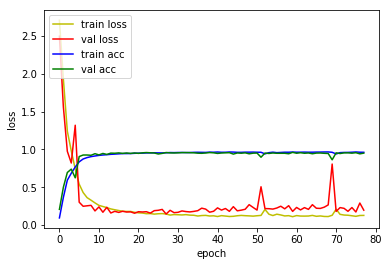

4815/4815 [==============================] - 2s 378us/sample - loss: 0.2057 - acc: 0.9466
Loss: 0.20568351803128904 Accuracy: 0.9466251



In [10]:
for i in range(3, 10):
    base = '1D_CNN_custom_ch_32_DO_075_DO_SGD'
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_ch_32_DO(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', 
                  optimizer=SGD(lr=0.01, momentum=0.9, decay=1e-6, nesterov=True),
                  metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_ch_32_DO_075_DO_SGD'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(3, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_ch_32_DO_075_DO_SGD_3_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_42 (Conv1D)           (None, 16000, 32)         192       
_________________________________________________________________
activation_42 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 16000, 32)         5152      
_________________________________________________________________
activation_43 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
max_pooling1d_35 (MaxPooling (None, 5333, 32)          0         
_________________________________________________________________
conv1d_44 (Conv1D)           (None, 5333, 32)          5152      
_________________________________________________________________
activation_44 (Activation)  

4815/4815 [==============================] - 2s 365us/sample - loss: 0.3395 - acc: 0.9063
Loss: 0.33951914914548087 Accuracy: 0.9063344

1D_CNN_custom_ch_32_DO_075_DO_SGD_7_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_60 (Conv1D)           (None, 16000, 32)         192       
_________________________________________________________________
activation_60 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_61 (Conv1D)           (None, 16000, 32)         5152      
_________________________________________________________________
activation_61 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
max_pooling1d_49 (MaxPooling (None, 5333, 32)          0         
_________________________________________________________________
conv1d_62 (Conv1D)      

4815/4815 [==============================] - 2s 413us/sample - loss: 0.2057 - acc: 0.9466
Loss: 0.20568351803128904 Accuracy: 0.9466251


In [12]:
for i in range(3, 10):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)


1D_CNN_custom_ch_32_DO_075_DO_SGD_3_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_42 (Conv1D)           (None, 16000, 32)         192       
_________________________________________________________________
activation_42 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 16000, 32)         5152      
_________________________________________________________________
activation_43 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
max_pooling1d_35 (MaxPooling (None, 5333, 32)          0         
_________________________________________________________________
conv1d_44 (Conv1D)           (None, 5333, 32)          5152      
_________________________________________________________________
activation_44 (Activation)  

4815/4815 [==============================] - 2s 418us/sample - loss: 0.3510 - acc: 0.9059
Loss: 0.3510391135701014 Accuracy: 0.905919

1D_CNN_custom_ch_32_DO_075_DO_SGD_7_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_60 (Conv1D)           (None, 16000, 32)         192       
_________________________________________________________________
activation_60 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_61 (Conv1D)           (None, 16000, 32)         5152      
_________________________________________________________________
activation_61 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
max_pooling1d_49 (MaxPooling (None, 5333, 32)          0         
_________________________________________________________________
conv1d_62 (Conv1D)        

4815/4815 [==============================] - 2s 444us/sample - loss: 0.2891 - acc: 0.9360
Loss: 0.28911270132657774 Accuracy: 0.93603325
